In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')  # For Streamlit predictions

print(train_df.shape)  # Expect ~7000+ rows, 20+ cols
print(train_df.head())
print(train_df['Churn'].value_counts())  # Binary target: Yes/No
print(train_df.info())  # Features: categorical (gender, etc.), numerical (tenure, charges)
print(train_df.describe())

(5634, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  4223-BKEOR  Female              0      No        Yes      21          Yes   
1  6035-RIIOM  Female              0      No         No      54          Yes   
2  3797-VTIDR    Male              0     Yes         No       1           No   
3  2568-BRGYX    Male              0      No         No       4          Yes   
4  2775-SEFEE    Male              0      No        Yes       0          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0                No             DSL            Yes  ...              Yes   
1               Yes     Fiber optic             No  ...               No   
2  No phone service             DSL             No  ...               No   
3                No     Fiber optic             No  ...               No   
4               Yes             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

In [38]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [39]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [40]:
df['Churn'].value_counts()

Churn
No     4128
Yes    1496
Name: count, dtype: int64

In [41]:
# Drop ID, separate target
train_df = train_df.drop('customerID', axis=1)
X = train_df.drop('Churn', axis=1)
y = (train_df['Churn'] == 'Yes').astype(int)  # Binary 0/1

# Label encode categoricals
le = LabelEncoder()
cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Scale numerics
scaler = StandardScaler()
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save preprocessors
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Preprocessing complete.")


Preprocessing complete.


Missing values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Duplicates: 16
New features added: AvgMonthlyCharges, HighValueCustomer, LongTerm


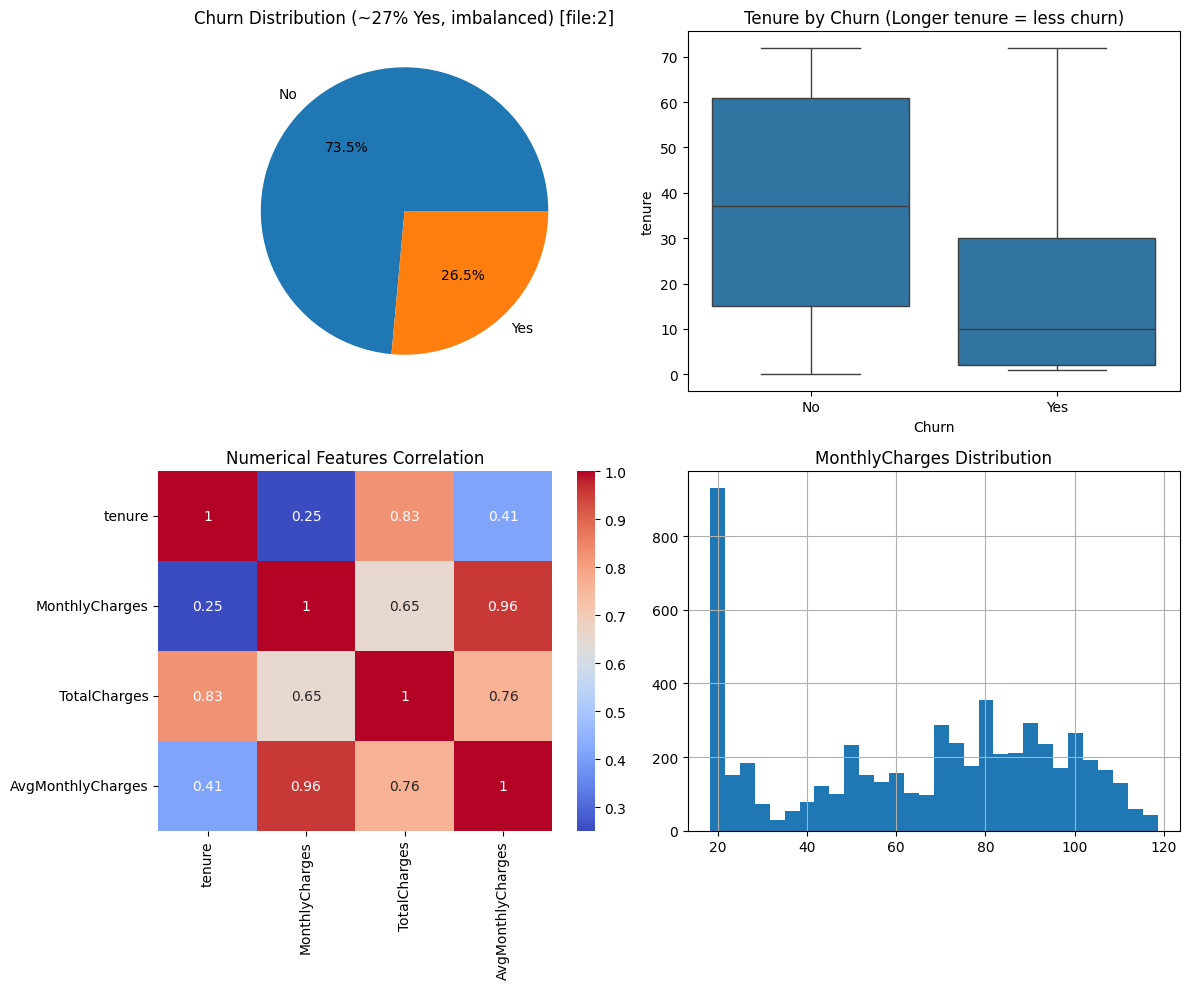

EDA complete. Shapes: (5618, 22) (5618,)


In [42]:
# Check data quality (no major missing/duplicates expected, but handle TotalCharges)
print("Missing values:\n", train_df.isnull().sum())  # TotalCharges may have ~11 blanks as ' '
train_df['TotalCharges'] = pd.to_numeric(train_df['TotalCharges'], errors='coerce').fillna(train_df['MonthlyCharges'] * train_df['tenure'])
print("Duplicates:", train_df.duplicated().sum())  # Remove if any
train_df = train_df.drop_duplicates()

# Outlier removal (IQR on numericals)
num_cols_eng = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols_eng:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    train_df = train_df[(train_df[col] >= Q1 - 1.5*IQR) & (train_df[col] <= Q3 + 1.5*IQR)]

# New features (domain-specific for churn)
train_df['AvgMonthlyCharges'] = train_df['TotalCharges'] / (train_df['tenure'] + 1)  # Avoid div0
train_df['HighValueCustomer'] = (train_df['MonthlyCharges'] > train_df['MonthlyCharges'].quantile(0.75)).astype(int)
train_df['LongTerm'] = (train_df['tenure'] > 24).astype(int)  # Key churn driver
print("New features added: AvgMonthlyCharges, HighValueCustomer, LongTerm")

# Class imbalance check
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# 1. Target distribution
churn_rate = train_df['Churn'].value_counts(normalize=True)
axes[0,0].pie(churn_rate.values, labels=churn_rate.index, autopct='%1.1f%%')
axes[0,0].set_title('Churn Distribution (~27% Yes, imbalanced) [file:2]')
# 2. Tenure vs Churn boxplot
sns.boxplot(data=train_df, x='Churn', y='tenure', ax=axes[0,1])
axes[0,1].set_title('Tenure by Churn (Longer tenure = less churn)')
# 3. Correlation heatmap (top features)
corr = train_df[num_cols_eng + ['AvgMonthlyCharges']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1,0])
axes[1,0].set_title('Numerical Features Correlation')
# 4. MonthlyCharges distribution
train_df['MonthlyCharges'].hist(bins=30, ax=axes[1,1])
axes[1,1].set_title('MonthlyCharges Distribution')
plt.tight_layout()
plt.savefig('eda_charts.png')
plt.show()

# Update X with new features before encoding/splitting
X = train_df.drop('Churn', axis=1)
y = (train_df['Churn'] == 'Yes').astype(int)
print("EDA complete. Shapes:", X.shape, y.shape)  # Now ~21+ features


In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Balanced train shapes:", X_train_bal.shape, y_train_bal.value_counts())
# Use X_train_bal, y_train_bal in model.fit() below for better recall/F1 on minority class


Balanced train shapes: (6620, 19) Churn
0    3310
1    3310
Name: count, dtype: int64


                     Accuracy     AUC  Precision  Recall      F1     MCC
Logistic Regression    0.7604  0.8552     0.5335  0.7726  0.6311  0.4798
Decision Tree          0.7223  0.6555     0.4781  0.5117  0.4943  0.3035
KNN                    0.6974  0.7718     0.4564  0.7358  0.5634  0.3742
Naive Bayes            0.7542  0.8337     0.5253  0.7625  0.6221  0.4661
Random Forest          0.7782  0.8241     0.5878  0.5485  0.5675  0.4190
XGBoost                0.7879  0.8260     0.6079  0.5652  0.5858  0.4441


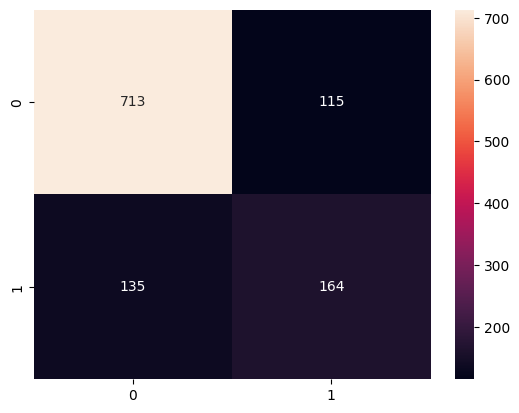

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)  # Balanced data boosts performance
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    
    # Save model
    joblib.dump(model, f'{name.replace(" ", "_").replace("-", "_")}.pkl')
    
    # Confusion matrix for Streamlit (save one, e.g., best model)
    if name == 'Random Forest':  # Example best
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.savefig('confusion_matrix.png')

# Comparison table (copy to README)
results_df = pd.DataFrame(results).T.round(4)
print(results_df)
